In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt

In [20]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
print(device)

cpu


In [23]:
from sklearn.model_selection import train_test_split

# Split indices for train/validation
train_indices, val_indices = train_test_split(
    np.arange(len(train_dataset)), test_size=0.2, random_state=42, shuffle=True)

In [24]:
class CustomMNISTDataset(Dataset):
  def __init__(self, csv_file, transform=None, is_test=False):
    self.data = pd.read_csv(csv_file)
    self.transform = transform
    self.is_test = is_test

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    item = self.data.iloc[idx]

    if self.is_test:
      image = item.values.reshape(28, 28).astype(np.uint8)
      label = None
    else:
      image = item[1:].values.reshape(28, 28).astype(np.uint8)
      label = item.iloc[0]

    image = transforms.ToPILImage()(image)

    if self.transform is not None:
      image = self.transform(image)

    if self.is_test:
      return image
    else:
      return image, label

In [25]:
transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [26]:
# Path to the folder containing the dataset files
path = "/kaggle/input/digit-recognizer"

# List all files in that folder
files = os.listdir(path)
print(files)

['sample_submission.csv', 'train.csv', 'test.csv']


In [38]:
train_dataset = CustomMNISTDataset(csv_file=os.path.join(path, 'train.csv'), transform=transform, is_test=False)
test_dataset = CustomMNISTDataset(csv_file=os.path.join(path, 'test.csv'), transform=transform, is_test=True)
print('Full Train Size: ' + str(len(train_dataset)) +', Test Size: ' + str(len(test_dataset)))

Full Train Size: 42000, Test Size: 28000


In [39]:
from torch.utils.data import random_split

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2)

In [40]:
train_dataset[1]

(tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.000

In [41]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Input Size: torch.Size([64, 1, 28, 28])


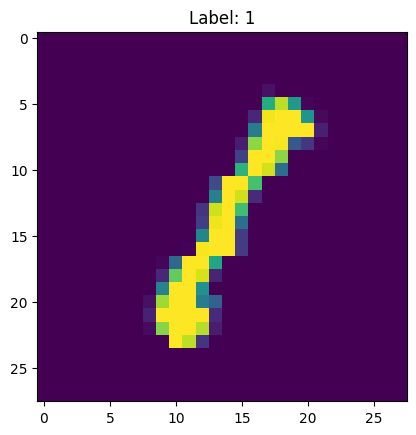

In [42]:
for example_data, example_labels in train_loader:
  example_image = example_data[0]
  print("Input Size:", example_data.size())

  example_image_numpy = example_image.permute(1, 2, 0).numpy()

  plt.imshow(example_image_numpy)
  plt.title(f'Label: {example_labels[0]}')
  plt.show()

  break

In [43]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
        # Flattened size after conv + pool: 128*7*7
        self.fc1 = nn.Linear(128 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)  # 10 classes for MNIST

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        
        x = x.view(x.size(0), -1)  # flatten except batch dimension
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [44]:
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [45]:
num_epochs = 100
running_loss = 0.0

patience = 10      
best_val_loss = float('inf')
trigger_times = 0
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f'Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {running_loss / 100}')
            running_loss = 0.0

    # --- Validation step ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    print(f'Epoch {epoch+1} Validation Loss: {val_loss:.4f}')

    # --- Early stopping check ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

Epoch: 1, Batch: 100, Loss: 0.8049618650972843
Epoch: 1, Batch: 200, Loss: 0.26000945426523686
Epoch: 1, Batch: 300, Loss: 0.21197907775640487
Epoch: 1, Batch: 400, Loss: 0.1615475196391344
Epoch: 1, Batch: 500, Loss: 0.17333012856543065
Epoch: 1, Batch: 600, Loss: 0.14830302538350223
Epoch 1 Validation Loss: 0.0674
Epoch: 2, Batch: 100, Loss: 0.11254524478688836
Epoch: 2, Batch: 200, Loss: 0.1233158627524972
Epoch: 2, Batch: 300, Loss: 0.10695932413451374
Epoch: 2, Batch: 400, Loss: 0.10062926536425948
Epoch: 2, Batch: 500, Loss: 0.10382881655357779
Epoch: 2, Batch: 600, Loss: 0.10263962538912892
Epoch 2 Validation Loss: 0.0475
Epoch: 3, Batch: 100, Loss: 0.08701369190239347
Epoch: 3, Batch: 200, Loss: 0.07501049472484737
Epoch: 3, Batch: 300, Loss: 0.07564542716369033
Epoch: 3, Batch: 400, Loss: 0.08587569449096918
Epoch: 3, Batch: 500, Loss: 0.08508513727225363
Epoch: 3, Batch: 600, Loss: 0.08738437296822667
Epoch 3 Validation Loss: 0.0431
Epoch: 4, Batch: 100, Loss: 0.0720213484298

In [47]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images.float())
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_acc = 100 * correct / total
print(f'Epoch: {epoch + 1}, Validation Accuracy: {val_acc:.2f}%')

print('Finished Training')

# Test prediction
model.eval()
predictions = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        outputs = model(data.float())
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().tolist())

submission = pd.DataFrame({
    'ImageId': range(1, len(predictions) + 1),
    'Label': predictions
})

submission.to_csv('submission.csv', index=False)
print("Submission saved!")

Epoch: 80, Validation Accuracy: 99.88%
Finished Training
Submission saved!


In [48]:
import zipfile

with zipfile.ZipFile('submission.zip', 'w') as z:
    z.write('submission.csv')

print("Zipped!")

Zipped!
